# Задание:
1. Выбрать тематику научных публикаций, любую область знаний, например, machine learning или artificial intelligence. 
2. Скачать с https://arxiv.org/ данные о научных публикациях по выбранной тематике. Выгрузить названия, авторов и аннотации статей. Скачивать через api https://info.arxiv.org/help/api/user-manual.html. Не менее 250 публикаций. 
3. Выделить ключевые слова по каждой публикации (используйте названия и аннотации). 
4. Построить связи между ключевыми словами на основе их принадлежности публикациям с использованием библиотеки https://networkx.org/ (как альтернативный вариант можно посмотреть https://graph-tool.skewed.de/static/doc/index.html, https://cosmograph.app/docs/cosmograph/Cosmograph%20Python/configuration/)
5. Определить кластеры ключевых слов на графе. Оценить качество кластеризации (например, по модулярности). Интерпретировать результат.
6. Найти ключевые слова с наибольшими значениями центральности в выбранной тематике (например, degree centrality, betweenness centrality, eigenvector centrality, closeness centrality). Интерпретировать результаты.
7. Построить граф публикаций: если ключевое слово является тегом для двух публикаций, значит, между ними связь есть. Чем больше общих ключевых слов, тем сильнее связь (выше вес ребра). Реализовать поиск наиболее близких к заданной пользователем публикаций на графе.
# Критерии оценки:
- Сбор данных и выделение ключевых слов (пункты 1-2). Оценивается качество построения визуализаций, полнота и логика описания данных в отчете. (10 баллов)
- Построение и анализ графа ключевых слов. Оценивается полнота проведенного анализа, корректность реализации и интерпретация результатов. (12 баллов)
- Поиск по графу публикаций. Оценивается подход к поиску и корректность его реализации, полнота и логика описания решения в отчете. (8 баллов)


---
### 0. Импорты, скачивания

In [1]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu129
%pip install requests feedparser pandas pdfplumber requests_cache diskcache yake networkx matplotlib scipy seaborn textblob stanza wordcloud cosmograph ipympl python-louvain scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu129
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from urllib.parse import urlencode
import diskcache
import requests
import feedparser
import re
import pandas as pd
import pdfplumber
import io
import requests_cache
import logging as logging_main
from typing import Optional, TypedDict
import functools
import yake
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
import itertools
import seaborn as sns
import stanza
import nltk
from nltk.corpus import stopwords
from torch.cuda import get_device_name, is_available
from wordcloud import WordCloud
from cosmograph import cosmo
import community as community_louvain
from sklearn.cluster import SpectralClustering, DBSCAN
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


logging = logging_main.getLogger("lab-1")
logging.setLevel(logging_main.INFO)

requests_cache.install_cache("arxiv_cache", expire_after=None)
disk_cache = diskcache.Cache("pdf_cache_dir")

logging.info(get_device_name(0))
stanza.download('en')
nlp = stanza.Pipeline('en', use_gpu=is_available())

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(background_color='white', max_words=50)


def cache(func):
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        key = (func.__name__, args, frozenset(kwargs.items()))
        if key in disk_cache:
            logging.info(f"Cache hit: {key}")
            return disk_cache[key]
        result = func(*args, **kwargs)
        disk_cache[key] = result
        return result
    return wrapper

2025-09-22 23:37:30 INFO: Downloaded file to C:\Users\HuTao1Love\stanza_resources\resources.json
2025-09-22 23:37:30 INFO: Downloading default packages for language: en (English) ...
2025-09-22 23:37:31 INFO: File exists: C:\Users\HuTao1Love\stanza_resources\en\default.zip
2025-09-22 23:37:33 INFO: Finished downloading models and saved to C:\Users\HuTao1Love\stanza_resources
2025-09-22 23:37:33 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-09-22 23:37:33 INFO: Downloaded file to C:\Users\HuTao1Love\stanza_resources\resources.json
2025-09-22 23:37:33 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2025-09-22 23:37:33 INFO: Using device: cuda
2025-09-22 23:37:33 INFO: Loading: tokenize
2025-09-22 23:37:35 INFO: Loading: mwt
2025-09-22 23:37:35 INFO: Loading: pos
2025-09-22 23:37:35 INFO: Loading: lemma
2025-09-22 23:37:36 INFO: Loading: constituency
2025-09-22 23:37:36 INFO: Loading: depparse
2025-09-22 23:37:36 INFO: Loading: sentiment
2025-09-22 23:37:36 INFO: Loadin

---
### 1. Выбрать тематику научных публикаций, любую область знаний, например, machine learning или artificial intelligence. 

In [3]:
# Config
BASE_URL = "https://export.arxiv.org/api/query"
CATEGORY = "cs.FL"  # Formal Languages and Automata Theory
RESULTS_COUNT = 250

---
### 2. Скачать с https://arxiv.org/ данные о научных публикациях по выбранной тематике. Выгрузить названия, авторов и аннотации статей. Скачивать через api https://info.arxiv.org/help/api/user-manual.html. Не менее 250 публикаций.

In [4]:
class Publication(TypedDict):
    title: str
    authors: list[str]
    summary: str
    keywords: Optional[list[str]]
    url: str


@cache
def fetch_pdf_keywords(url: str) -> list[str] | None:
    try:
        response = requests.get(url, timeout=(5, 60))
        response.raise_for_status()

        logging.info(f"Fetch {url}")

        with pdfplumber.open(io.BytesIO(response.content)) as pdf:
            text = "\n".join(page.extract_text() or "" for page in pdf.pages)

            keywords_match = re.search(
                r'(?i)(?:keywords?|KEYWORDS?):\s*([^\n]+)',
                text,
                re.IGNORECASE | re.DOTALL
            )

        return [kw.strip() for kw in keywords_match.group(1).split(',')] if keywords_match else None
    except Exception as e:
        logging.error(e)
        return None



def fetch_arxiv(category: str, results_count: int) -> list[Publication]:
    args = {
        "search_query": f"cat:{category}",
        "sortBy": "submittedDate",
        "sortOrder": "descending",
        "max_results": results_count
    }

    response = requests.get(f"{BASE_URL}?{urlencode(args)}")
    response.raise_for_status()

    feed = feedparser.parse(response.text)

    # not parallel because there is SIGSEGV either :D
    return [
        Publication(
            title=entry.title,
            authors=[author.name for author in entry.authors],
            summary=entry.summary,
            keywords=fetch_pdf_keywords(entry.id.replace("abs", "pdf")),
            url=entry.id.replace('abs', 'pdf'),
        )
        for entry in feed.entries
    ]

papers = fetch_arxiv(CATEGORY, RESULTS_COUNT)
papers

[{'title': 'Weighted Automata for Exact Inference in Discrete Probabilistic Programs',
  'authors': ['Dominik Geißler', 'Tobias Winkler'],
  'summary': 'In probabilistic programming, the inference problem asks to determine a\nprogram\'s posterior distribution conditioned on its "observe" instructions.\nInference is challenging, especially when exact rather than approximate results\nare required. Inspired by recent work on probability generating functions\n(PGFs), we propose encoding distributions on $\\mathbb{N}^k$ as weighted\nautomata over a commutative alphabet with $k$ symbols. Based on this, we map\nthe semantics of various imperative programming statements to\nautomata-theoretic constructions. For a rich class of programs, this results in\nan effective translation from prior to posterior distribution, both encoded as\nautomata. We prove that our approach is sound with respect to a standard\noperational program semantics.',
  'keywords': ['Weighted Automata · Probabilistic Program

In [5]:
print(len(papers))
df = pd.DataFrame(papers)
print(df.isnull().sum())
df.sample(10, random_state=52)

250
title         0
authors       0
summary       0
keywords    194
url           0
dtype: int64


,title,authors,summary,keywords,url
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...",None,http://arxiv.org/pdf/2509.03004v1
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[Formal verification, Machine learning]",http://arxiv.org/pdf/2506.12084v1
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[n, meaning]",http://arxiv.org/pdf/2509.00837v1
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,None,http://arxiv.org/pdf/2508.12853v1
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,None,http://arxiv.org/pdf/2504.15668v1
203,Active Learning of Upward-Closed Sets of Words,[Quentin Aristote],We give a new proof of a result from well quas...,None,http://arxiv.org/pdf/2504.21429v2
26,Controller synthesis method for multi-agent sy...,"[Ruohan Huang, Zining Cao]",Controller synthesis is a theoretical approach...,None,http://arxiv.org/pdf/2509.00870v1
168,Automata Learning of Preferences over Temporal...,"[Hazhar Rahmani, Jie Fu]",Many preference elicitation algorithms conside...,[Automatalearning;Temporallogicinference;Prefe...,http://arxiv.org/pdf/2505.18030v1
91,Hyper pattern matching,"[Masaki Waga, Étienne André]","In runtime verification, pattern matching, whi...",[runtimeverification·hyperproperties·patternma...,http://arxiv.org/pdf/2507.12102v1
114,On the Reachability Problem for Two-Dimensiona...,"[Clotilde Bizière, Thibault Hilaire, Jérôme Le...","Vectors addition systems with states (VASS), o...",None,http://arxiv.org/pdf/2506.22561v1


---
### 3. Выделить ключевые слова по каждой публикации (используйте названия и аннотации).

In [6]:
yake_extractor = yake.KeywordExtractor(lan="en", n=4, dedupLim=0.85, top=20)


def update_keywords(row):
    extract_keywords = lambda text: [kw[0] for kw in yake_extractor.extract_keywords(text.lower())]

    existing_keywords = set(row["keywords"]) if isinstance(row["keywords"], list) else set()
    new_keywords = set(extract_keywords(row["title"] + " " + row["summary"]))

    updated_keywords = list(existing_keywords | new_keywords)
    return updated_keywords


df["keywords"] = df.apply(update_keywords, axis=1)
print(df.iloc[1].keywords)
df[['title', 'keywords']].head(5)

['scalar algebras due', 'syntactic vector spaces', 'finite-dimensionality of syntactic vector', 'recognizable weighted', 'weighted tree languages', 'tree languages', 'cancellative scalar algebras', 'languages over commutative', 'deterministically recognizable weighted tree', 'deterministically recognizable weighted', 'well-known characterization of recognizable', 'languages over commutative semifields', 'cancellative scalar algebras due', 'recognizable weighted tree', 'weighted tree', 'tree languages over fields', 'recognizable weighted tree languages', 'tree languages over commutative', 'respective m-syntactic scalar algebras', 'bottom-up deterministically recognizable weighted']


,title,keywords
0,Weighted Automata for Exact Inference in Discr...,"[probabilistic programs in probabilistic, infe..."
1,Characterization of deterministically recogniz...,"[scalar algebras due, syntactic vector spaces,..."
2,Active Learning of Symbolic Mealy Automata,"[learning algorithm that learns, infinite inpu..."
3,On the Complexity of the Secret Protection Pro...,"[initial state, minimum-cost policy, minimum-c..."
4,The Complexity of Generalized HyperLTL with St...,"[stuttering, complexity of generalized, comple..."


In [7]:
def lemmatize_keywords_stanza(keywords):
    lemmatized_phrases = []

    for phrase in keywords:
        doc = nlp(phrase)
        lemmatized_words = [word.lemma for word in doc.iter_words()]
        lemmatized_phrases.append(" ".join(lemmatized_words))

    return lemmatized_phrases


df['lemmatized_keywords'] = df['keywords'].apply(lambda row: lemmatize_keywords_stanza(row))
print(*df[['keywords', 'lemmatized_keywords']].iloc[1].values, sep='\n')
df.sample(5, random_state=52)

['scalar algebras due', 'syntactic vector spaces', 'finite-dimensionality of syntactic vector', 'recognizable weighted', 'weighted tree languages', 'tree languages', 'cancellative scalar algebras', 'languages over commutative', 'deterministically recognizable weighted tree', 'deterministically recognizable weighted', 'well-known characterization of recognizable', 'languages over commutative semifields', 'cancellative scalar algebras due', 'recognizable weighted tree', 'weighted tree', 'tree languages over fields', 'recognizable weighted tree languages', 'tree languages over commutative', 'respective m-syntactic scalar algebras', 'bottom-up deterministically recognizable weighted']
['scalar algebra due', 'syntactic vector space', 'finite - dimensionality of syntactic vector', 'recognizable weight', 'weight tree language', 'tree language', 'cancellative scalar algebra', 'language over commutative', 'deterministically recognizable weight tree', 'deterministically recognizable weight', 'we

,title,authors,summary,keywords,url,lemmatized_keywords
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...","[models, processes to make sense, model, gener...",http://arxiv.org/pdf/2509.03004v1,"[model, process to make sense, model, generate..."
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[leading to a profusion, specification and ver...",http://arxiv.org/pdf/2506.12084v1,"[lead to a profusion, specification and verifi..."
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[theory drew attention, finite semigroupoids r...",http://arxiv.org/pdf/2509.00837v1,"[theory draw attention, finite semigroupoid re..."
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,"[admits a path, box whose opposite, box reacha...",http://arxiv.org/pdf/2508.12853v1,"[admit a path, box whose opposite, box reachab..."
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,"[hybrid planning problems explaining, research...",http://arxiv.org/pdf/2504.15668v1,"[hybrid planning problem explain, research int..."


In [8]:
def clean_keywords(keywords):
    cleaned_keywords = [
        " ".join([word for word in phrase.split() if word not in stop_words])
        for phrase in keywords
    ]

    return [i for i in cleaned_keywords if i]


df['cleaned_keywords'] = df['lemmatized_keywords'].apply(clean_keywords)
print(*df.iloc[1].cleaned_keywords, sep='\n')
df.sample(5, random_state=52)

scalar algebra due
syntactic vector space
finite - dimensionality syntactic vector
recognizable weight
weight tree language
tree language
cancellative scalar algebra
language commutative
deterministically recognizable weight tree
deterministically recognizable weight
well - know characterization recognizable
language commutative semifield
cancellative scalar algebra due
recognizable weight tree
weight tree
tree language field
recognizable weight tree language
tree language commutative
respective m-syntactic scalar algebra
bottom - deterministically recognizable weight


,title,authors,summary,keywords,url,lemmatized_keywords,cleaned_keywords
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...","[models, processes to make sense, model, gener...",http://arxiv.org/pdf/2509.03004v1,"[model, process to make sense, model, generate...","[model, process make sense, model, generate cl..."
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[leading to a profusion, specification and ver...",http://arxiv.org/pdf/2506.12084v1,"[lead to a profusion, specification and verifi...","[lead profusion, specification verification, v..."
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[theory drew attention, finite semigroupoids r...",http://arxiv.org/pdf/2509.00837v1,"[theory draw attention, finite semigroupoid re...","[theory draw attention, finite semigroupoid re..."
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,"[admits a path, box whose opposite, box reacha...",http://arxiv.org/pdf/2508.12853v1,"[admit a path, box whose opposite, box reachab...","[admit path, box whose opposite, box reachabil..."
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,"[hybrid planning problems explaining, research...",http://arxiv.org/pdf/2504.15668v1,"[hybrid planning problem explain, research int...","[hybrid planning problem explain, research int..."


In [9]:
df.describe()

,title,authors,summary,keywords,url,lemmatized_keywords,cleaned_keywords
count,250,250,250,250,250,250,250
unique,250,246,250,250,250,250,250
top,Weighted Automata for Exact Inference in Discr...,"[Bruno Guillon, Luca Prigioniero, Javad Taheri]","In probabilistic programming, the inference pr...","[probabilistic programs in probabilistic, infe...",http://arxiv.org/pdf/2509.15074v1,"[probabilistic program in probabilistic, infer...","[probabilistic program probabilistic, inferenc..."
freq,1,2,1,1,1,1,1


C:\Users\HuTao1Love\AppData\Local\Temp\ipykernel_4488\1136677713.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")


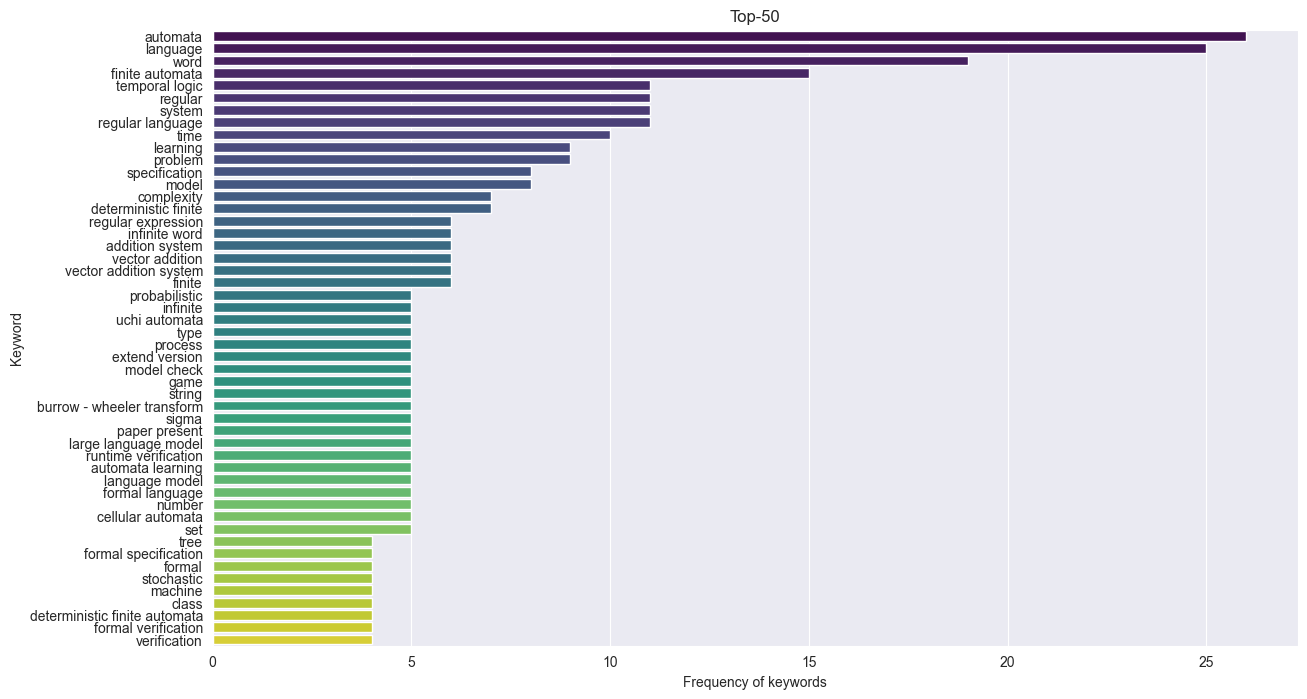

In [10]:
all_keywords = [word for keywords in df['cleaned_keywords'] for word in keywords]
keyword_freq = Counter(all_keywords)

most_common_keywords = keyword_freq.most_common(50)
top_keywords = dict(most_common_keywords)
plt.figure(figsize=(14, 8))
sns.barplot(x=list(top_keywords.values()), y=list(top_keywords.keys()), palette="viridis")
plt.xlabel('Frequency of keywords')
plt.ylabel('Keyword')
plt.title('Top-50')
plt.show()

In [11]:
df.sample(10, random_state=52)

,title,authors,summary,keywords,url,lemmatized_keywords,cleaned_keywords
19,Identifiability and minimality bounds of quant...,"[Paul M. Riechers, Thomas J. Elliott]","To make sense of the world around us, we devel...","[models, processes to make sense, model, gener...",http://arxiv.org/pdf/2509.03004v1,"[model, process to make sense, model, generate...","[model, process make sense, model, generate cl..."
144,The CAISAR Platform: Extending the Reach of Ma...,"[Michele Alberti, François Bobot, Julien Girar...",The formal specification and verification of m...,"[leading to a profusion, specification and ver...",http://arxiv.org/pdf/2506.12084v1,"[lead to a profusion, specification and verifi...","[lead profusion, specification verification, v..."
27,Computational Exploration of Finite Semigroupoids,"[Attila Egri-Nagy, Chrystopher L. Nehaniv]",Recent algorithmic advances in algebraic autom...,"[theory drew attention, finite semigroupoids r...",http://arxiv.org/pdf/2509.00837v1,"[theory draw attention, finite semigroupoid re...","[theory draw attention, finite semigroupoid re..."
52,Box-Reachability in Vector Addition Systems,"[Shaull Almagor, Itay Hasson, Michał Pilipczuk...",We consider a variant of reachability in Vecto...,"[admits a path, box whose opposite, box reacha...",http://arxiv.org/pdf/2508.12853v1,"[admit a path, box whose opposite, box reachab...","[admit path, box whose opposite, box reachabil..."
225,Exploring Inevitable Waypoints for Unsolvabili...,"[Mir Md Sajid Sarwar, Rajarshi Ray]",Explaining unsolvability of planning problems ...,"[hybrid planning problems explaining, research...",http://arxiv.org/pdf/2504.15668v1,"[hybrid planning problem explain, research int...","[hybrid planning problem explain, research int..."
203,Active Learning of Upward-Closed Sets of Words,[Quentin Aristote],We give a new proof of a result from well quas...,"[upward-closed sets of words, quasi-order theo...",http://arxiv.org/pdf/2504.21429v2,"[upward - close set of word, quasi - order the...","[upward - close set word, quasi - order theory..."
26,Controller synthesis method for multi-agent sy...,"[Ruohan Huang, Zining Cao]",Controller synthesis is a theoretical approach...,"[control, specification controller synthesis, ...",http://arxiv.org/pdf/2509.00870v1,"[control, specification controller synthesis, ...","[control, specification controller synthesis, ..."
168,Automata Learning of Preferences over Temporal...,"[Hazhar Rahmani, Jie Fu]",Many preference elicitation algorithms conside...,"[logic, temporal goals, preorder, logic formul...",http://arxiv.org/pdf/2505.18030v1,"[logic, temporal goal, preorder, logic formula...","[logic, temporal goal, preorder, logic formula..."
91,Hyper pattern matching,"[Masaki Waga, Étienne André]","In runtime verification, pattern matching, whi...","[matching in runtime verification, matching, h...",http://arxiv.org/pdf/2507.12102v1,"[match in runtime verification, match, hyper p...","[match runtime verification, match, hyper patt..."
114,On the Reachability Problem for Two-Dimensiona...,"[Clotilde Bizière, Thibault Hilaire, Jérôme Le...","Vectors addition systems with states (VASS), o...","[analysis of concurrent, vectors addition syst...",http://arxiv.org/pdf/2506.22561v1,"[analysis of concurrent, vector addition syste...","[analysis concurrent, vector addition system, ..."


---
### 4. Построить связи между ключевыми словами на основе их принадлежности публикациям с использованием библиотеки https://networkx.org/ (как альтернативный вариант можно посмотреть https://graph-tool.skewed.de/static/doc/index.html, https://cosmograph.app/docs/cosmograph/Cosmograph%20Python/configuration/)

In [12]:
keywords_list = [item for sublist in df['cleaned_keywords'] for item in sublist]
unique_keywords = list(set(keywords_list))

points = pd.DataFrame({
    'id': range(len(unique_keywords)),
    'label': unique_keywords,
    'value': [keywords_list.count(keyword) for keyword in unique_keywords],
    'category': ['General' for _ in unique_keywords]
})

points.sort_values(by='value', ascending=False)

,id,label,value,category
3364,3364,automata,26,General
663,663,language,25,General
3589,3589,word,19,General
3709,3709,finite automata,15,General
1897,1897,regular,11,General
...,...,...,...,...
4514,4514,development regular expression,1,General
4515,4515,wide range domain,1,General
4516,4516,learn weight automata,1,General
4517,4517,nondeterminism chance history - deterministic,1,General


In [13]:
links_list = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair
        id_1 = points[points['label'] == keyword_1].id.values[0]
        id_2 = points[points['label'] == keyword_2].id.values[0]
        links_list.append({
            'source': id_1,
            'target': id_2,
            'value': 1.0,
        })

links = pd.DataFrame(links_list)
links.shape

(49812, 3)

In [14]:
widget = cosmo(
    points=points,
    links=links,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category',
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

display(widget)

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

In [15]:
filtered_points = points[points['value'] > 1]
filtered_points.sort_values(by='value', ascending=False)

,id,label,value,category
3364,3364,automata,26,General
663,663,language,25,General
3589,3589,word,19,General
3709,3709,finite automata,15,General
1897,1897,regular,11,General
...,...,...,...,...
4448,4448,characterize regular language,2,General
16,16,bound,2,General
4481,4481,programming language,2,General
4491,4491,addition,2,General


In [16]:
links_list_1 = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair

        if keyword_1 in filtered_points['label'].values and keyword_2 in filtered_points['label'].values:
            id_1 = filtered_points[filtered_points['label'] == keyword_1].id.values[0]
            id_2 = filtered_points[filtered_points['label'] == keyword_2].id.values[0]
            links_list_1.append({
                'source': id_1,
                'target': id_2,
                'value': 1.0,
            })

links_1 = pd.DataFrame(links_list_1)

widget = cosmo(
    points=filtered_points,
    links=links_1,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category',
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

print(links_1.shape)
widget

(1823, 3)


Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

---
### 5. Определить кластеры ключевых слов на графе. Оценить качество кластеризации (например, по модулярности). Интерпретировать результат.

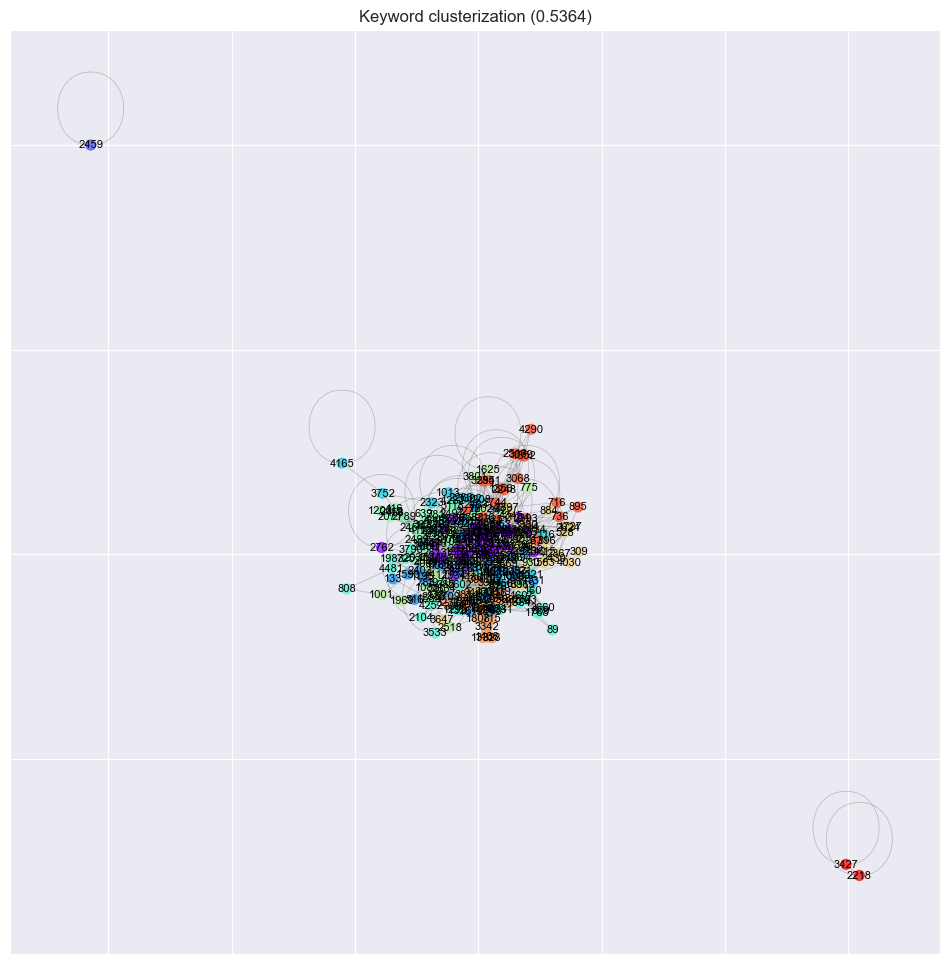

In [17]:
G = nx.Graph()

for _, row in filtered_points.iterrows():
    G.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_1.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

G = G.subgraph([node for node in G.nodes() if G.degree(node) >= 2])

partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)

node_colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Keyword clusterization ({modularity:.4f})")
plt.show()

In [18]:
cluster_info = {}
for node, cluster in partition.items():
    cluster_info.setdefault(cluster, []).append(G.nodes[node]['label'])

filtered_cluster_info = {cluster: keywords for cluster, keywords in cluster_info.items() if len(keywords) > 1}

for cluster, keywords in filtered_cluster_info.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")

Cluster 0: infinite, class, characterize, input, infinite word, language, family, alternate parity automata, chain, pushdown, parity automata, tree language, log, regular language, alternate parity, language finite tree, regular, introduce, parity, regular language finite, deterministic, first - order logic, infinite sequence, grammar, linear temporal logic, minimizer, burrow - wheeler transform, regular tree, automaton model, result, automata, dsa, regular tree language, tree, monoid, polynomial time, closure, uchi automata, sigma, input letter, omega, number, input word
Cluster 2: bound, finite state, absent, generalize abelian complexity, fix point, word avoid, cellular automata, generate group, proof system, morphism, elementary cellular, dynamical system, binary word, set position, elementary cellular automata, context - free language, complexity, finite word, critical exponent, letter, automata define, rational, cellular, finitely generate group, factor, function, finitely genera

In [19]:
filtered_points = points[points['label'].isin([keyword for cluster, keywords in filtered_cluster_info.items() if len(keywords) > 1 for keyword in keywords])]

links_list_2 = []
for keywords in df['cleaned_keywords']:
    for pair in itertools.combinations(keywords, 2):
        keyword_1, keyword_2 = pair

        if keyword_1 in filtered_points['label'].values and keyword_2 in filtered_points['label'].values:
            id_1 = filtered_points[filtered_points['label'] == keyword_1].id.values[0]
            id_2 = filtered_points[filtered_points['label'] == keyword_2].id.values[0]
            links_list_2.append({
                'source': id_1,
                'target': id_2,
                'value': 1.0,
            })

links_2 = pd.DataFrame(links_list_2)

widget = cosmo(
    points=filtered_points,
    links=links_2,
    point_id_by='id',
    link_source_by='source',
    link_target_by='target',
    point_color_by='category',
    point_include_columns=['value'],
    point_label_by='label',
    link_include_columns=['value'],
)

widget

Cosmograph(background_color=None, focused_point_ring_color=None, hovered_point_ring_color=None, link_color=Non…

### SpectralClustering

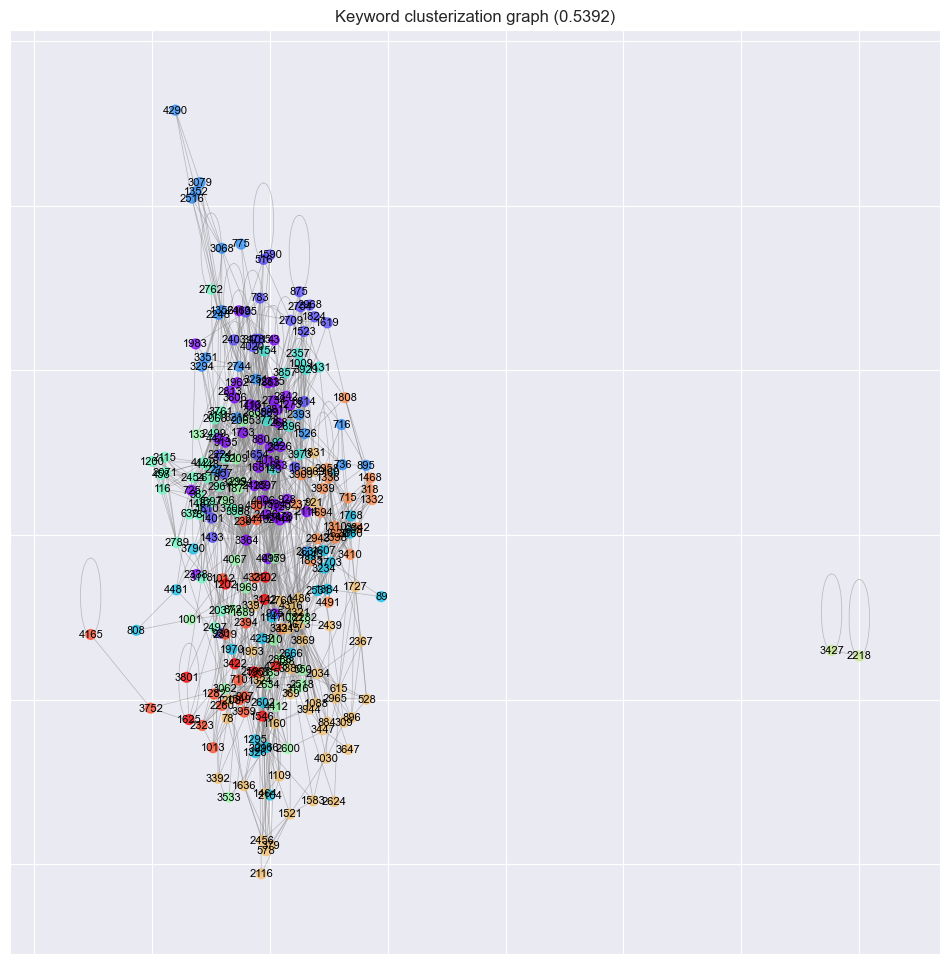

In [20]:
G = nx.Graph()

for _, row in filtered_points.iterrows():
    G.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_2.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['value'])

G = G.subgraph([node for node in G.nodes() if G.degree(node) >= 2])

partition = community_louvain.best_partition(G)

modularity = community_louvain.modularity(partition, G)
node_colors = [partition[node] for node in G.nodes()]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Keyword clusterization graph ({modularity:.4f})")
plt.show()

C:\Users\HuTao1Love\PycharmProjects\data-analysis\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


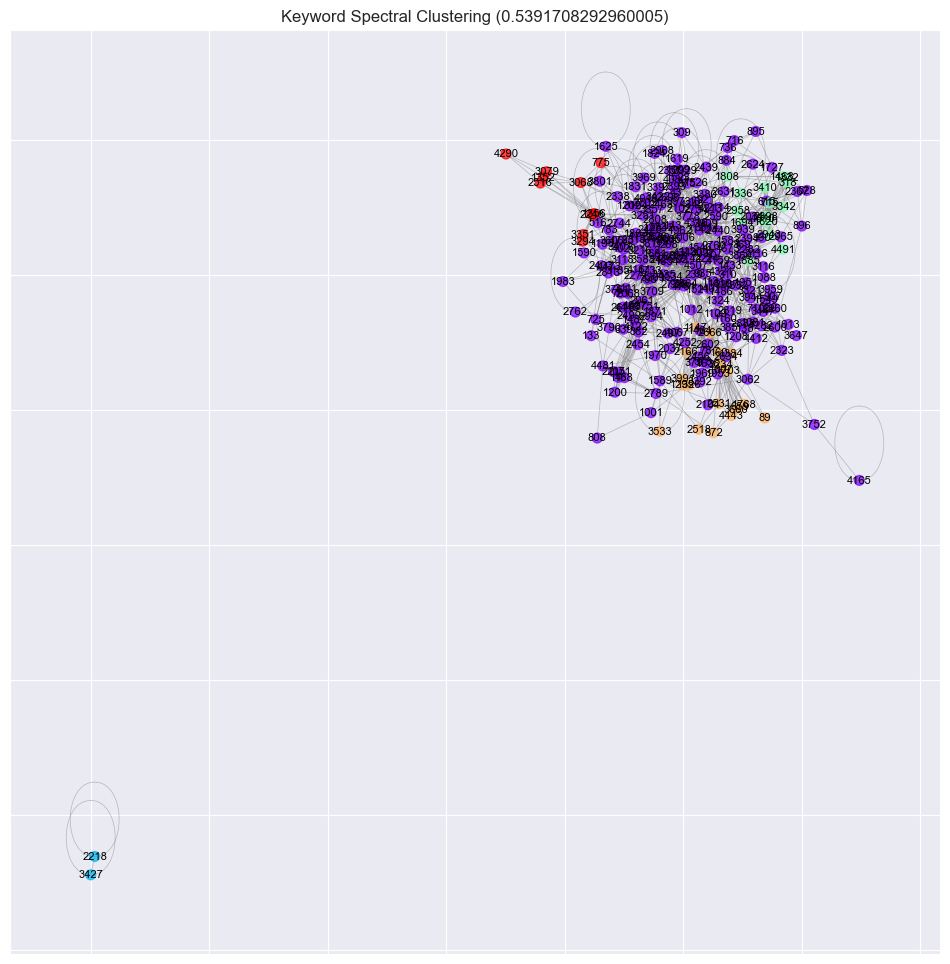

In [21]:
adjacency_matrix = nx.to_numpy_array(G)

clustering = SpectralClustering(5, affinity='precomputed', random_state=52)
labels = clustering.fit_predict(adjacency_matrix)

node_colors = labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Keyword Spectral Clustering ({modularity})")
plt.show()

Cluster 0: infinite, bound, finite state, probabilistic program, class, universal finite - state, absent, regular model, characterize, input, infinite word, signal temporal, synthesis, deterministic finite automaton, behavioural specification, decision process, model check, universal finite - state machine, generalize abelian complexity, verification technique, transition system, markov decision, runtime verification, low bound, language, automata learning, paper introduce, fundamental component, notion, automatic, fix point, digit, kleene algebra, word avoid, family, temporal, runtime monitor, observe trace, active automata, variety, alternate parity automata, computer scientist, chain, cellular automata, decision procedure, generate group, pushdown, passive automata learning, transition, Formal verification, markov chain, parity automata, proof system, extend version, morphism, network, graph, weight automata, tree language, automata learning algorithm, probabilistic, elementary cell

C:\Users\HuTao1Love\PycharmProjects\data-analysis\.venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


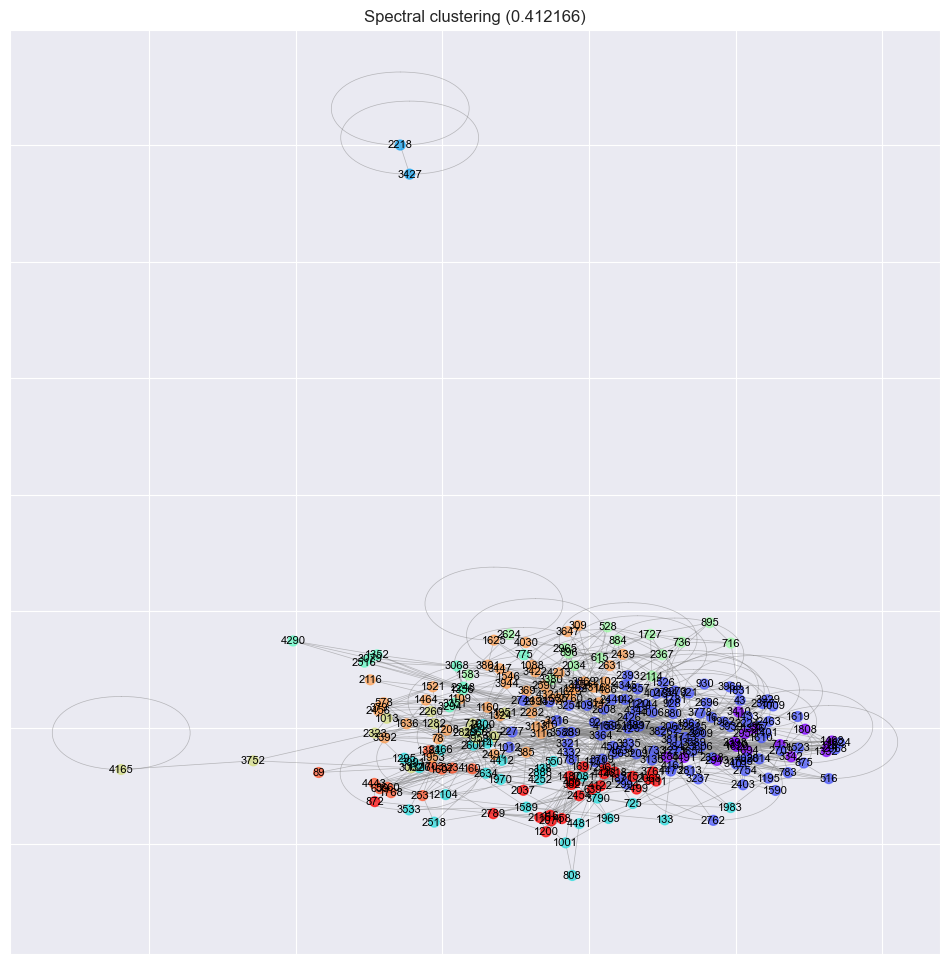

In [22]:
cluster_info = {}
for node, cluster in zip(G.nodes(), labels):
    cluster_info.setdefault(cluster, []).append(G.nodes[node]['label'])

for cluster, keywords in cluster_info.items():
    print(f"Cluster {cluster}: {', '.join(keywords)}")

node_cluster = {node: label for node, label in zip(G.nodes(), labels)}
m = G.size(weight='weight')
degrees = dict(G.degree(weight='weight'))

Q = 0.0
for u, v, data in G.edges(data=True):
    weight = data['weight'] if 'weight' in data else 1
    if node_cluster[u] == node_cluster[v]:
        Q += weight - (degrees[u] * degrees[v]) / (2 * m)

Q /= (2 * m)
clustering = SpectralClustering(n_clusters=10, affinity='precomputed', random_state=42)
labels = clustering.fit_predict(adjacency_matrix)

node_colors = labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=8, font_color='black')
nx.draw_networkx_edges(G, pos, width=0.5, alpha=0.5, edge_color='gray')
plt.title(f"Spectral clustering ({Q:4f})")
plt.show()

### DBSCAN

In [23]:
G_with_all_links = nx.Graph()

for _, row in filtered_points.iterrows():
    G_with_all_links.add_node(row['id'], label=row['label'], value=row['value'])

for _, row in links_2.iterrows():
    G_with_all_links.add_edge(row['source'], row['target'], weight=row['value'])

G_with_all_links = G_with_all_links.subgraph([node for node in G_with_all_links.nodes() if G_with_all_links.degree(node) >= 2])

adj_matrix = nx.to_numpy_array(G_with_all_links, weight='weight')
cosine_sim = cosine_similarity(adj_matrix)
dist_matrix = np.abs(1 - cosine_sim)

dbscan = DBSCAN(metric="precomputed", eps=0.1, min_samples=5)
labels = dbscan.fit_predict(dist_matrix)


Noise: infinite, bound, finite state, probabilistic program, code, class, universal finite - state, absent, regular model, characterize, mathsf, input, infinite word, signal temporal, synthesis, theoretical computer science, deterministic finite automaton, behavioural specification, decision process, model check, universal finite - state machine, generalize abelian complexity, verification technique, transition system, markov decision, runtime verification, low bound, transformer - base large, language, automata learning, addition system state, paper introduce, fundamental component, notion, active learning, automatic, fix point, digit, kleene algebra, hierarchy, word avoid, family, temporal, runtime monitor, observe trace, active automata, variety, alternate parity automata, computer scientist, chain, cellular automata, decision procedure, generate group, pushdown, passive automata learning, transition, Formal verification, markov chain, parity automata, proof system, formal language,

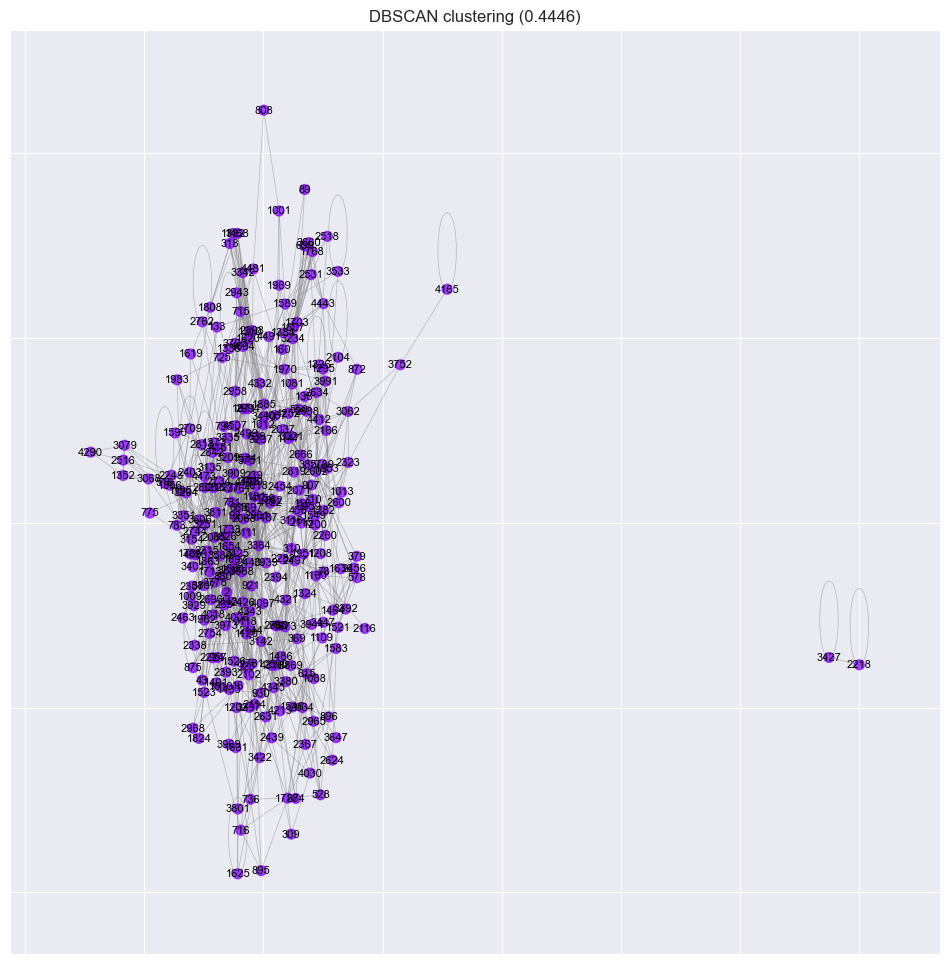

In [24]:
node_colors = labels
m = G_with_all_links.size(weight='weight')
partition = {node: label for node, label in zip(G_with_all_links.nodes(), labels)}
degrees = dict(G_with_all_links.degree(weight='weight'))

Q = 0.0
for u, v, data in G_with_all_links.edges(data=True):
    weight = data['weight'] if 'weight' in data else 1
    if partition[u] == partition[v]:
        expected_weight = (degrees[u] * degrees[v]) / (2 * m)
        Q += weight - expected_weight
Q /= (2 * m)

cluster_info = {}
for node, cluster in zip(G_with_all_links.nodes(), labels):
    cluster_info.setdefault(cluster, []).append(G_with_all_links.nodes[node]['label'])

for cluster, keywords in cluster_info.items():
    if cluster != -1:
        print(f"Cluster {cluster}: {', '.join(keywords)}")
    else:
        print(f"Noise: {', '.join(keywords)}")


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_with_all_links)

nx.draw_networkx_nodes(G_with_all_links, pos, node_color=node_colors, cmap=plt.cm.rainbow, node_size=50, alpha=0.7)
nx.draw_networkx_edges(G_with_all_links, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_with_all_links, pos, font_size=8, font_color='black')
plt.title(f"DBSCAN clustering ({Q:.4f})")
plt.show()

---
### 6. Найти ключевые слова с наибольшими значениями центральности в выбранной тематике (например, degree centrality, betweenness centrality, eigenvector centrality, closeness centrality). Интерпретировать результаты.

In [25]:
centralities = {
    "degree": lambda G: nx.degree_centrality(G),
    "betweenness": lambda G: nx.betweenness_centrality(G, weight='weight'),
    "eigenvector": lambda G: nx.eigenvector_centrality(G, weight='weight'),
    "closeness": lambda G: nx.closeness_centrality(G),
}

centralities = {
    key: sorted(f(G).items(), key=lambda x: x[1], reverse=True)[:10]
    for key, f in centralities.items()
}

centralities = {
    key: [f"{G_with_all_links.nodes[node]['label']}: {centrality}" for (node, centrality) in items]
    for key, items in centralities.items()
}

for (key, values) in centralities.items():
    print(key + ":", *values, sep='\n', end='\n\n')

degree:
automata: 0.29213483146067415
language: 0.24719101123595505
word: 0.20599250936329588
regular language: 0.17228464419475656
finite automata: 0.14606741573033707
regular: 0.1348314606741573
finite: 0.12734082397003746
complexity: 0.11235955056179775
problem: 0.10861423220973783
system: 0.10861423220973783

betweenness:
automata: 0.22826013696033817
language: 0.174492791981404
word: 0.08809454626342422
finite automata: 0.06136465452470345
system: 0.05247561614229512
complexity: 0.0509569358253317
regular language: 0.04616802571357298
temporal logic: 0.04317072625983062
problem: 0.036176088743037224
regular: 0.035790084669718454

eigenvector:
automata: 0.3114315272455227
language: 0.2899116139203378
word: 0.26408169665718934
regular language: 0.24716529393716488
finite: 0.2084352995281037
regular: 0.20578671451748318
finite automata: 0.1848144428356032
infinite word: 0.16172755316190968
infinite: 0.1419964648050069
tree: 0.12764396147903262

closeness:
automata: 0.5411830890399346

---
### 7. Построить граф публикаций: если ключевое слово является тегом для двух публикаций, значит, между ними связь есть. Чем больше общих ключевых слов, тем сильнее связь (выше вес ребра). Реализовать поиск наиболее близких к заданной пользователем публикаций на графе.

In [26]:
G_publications = nx.Graph()

for idx, row in df.iterrows():
    G_publications.add_node(idx, title=row['title'], authors=row['authors'], summary=row['summary'])

for idx, row in df.iterrows():
    keywords = set(row['cleaned_keywords'])

    for other_idx, other_row in df.iterrows():
        if idx == other_idx: continue

        other_keywords = set(other_row['cleaned_keywords'])
        common_keywords = keywords.intersection(other_keywords)
        if common_keywords:
            weight = len(common_keywords)
            G_publications.add_edge(idx, other_idx, weight=weight)


G_publications = G_publications.subgraph([node for node in G_publications.nodes() if G_publications.degree(node) >= 2])

Top 5 pagerank:
Deciding Sparseness of Regular Languages of Finite Trees and Infinite
  Words: 0.015343198281387718
Saturation Problems for Families of Automata: 0.015171296903997204
A Myhill-Nerode Type Characterization of 2detLIN Languages: 0.013369990839049061
On Complementation of Nondeterministic Finite Automata without Full
  Determinization (Technical Report): 0.012948555998818922
How Concise are Chains of co-Büchi Automata?: 0.012124864494118122

Top 5 betweenness:
On Complementation of Nondeterministic Finite Automata without Full
  Determinization (Technical Report): 0.0562127283167623
Addition Automata and Attractors of Digit Systems Corresponding to
  Expanding Rational Matrices: 0.05227184215797389
Componentwise Automata Learning for System Integration (Extended
  Version): 0.05100184315230035
Identifiability and minimality bounds of quantum and post-quantum models
  of classical stochastic processes: 0.046210047352617335
Learning Probabilistic Temporal Logic Specification

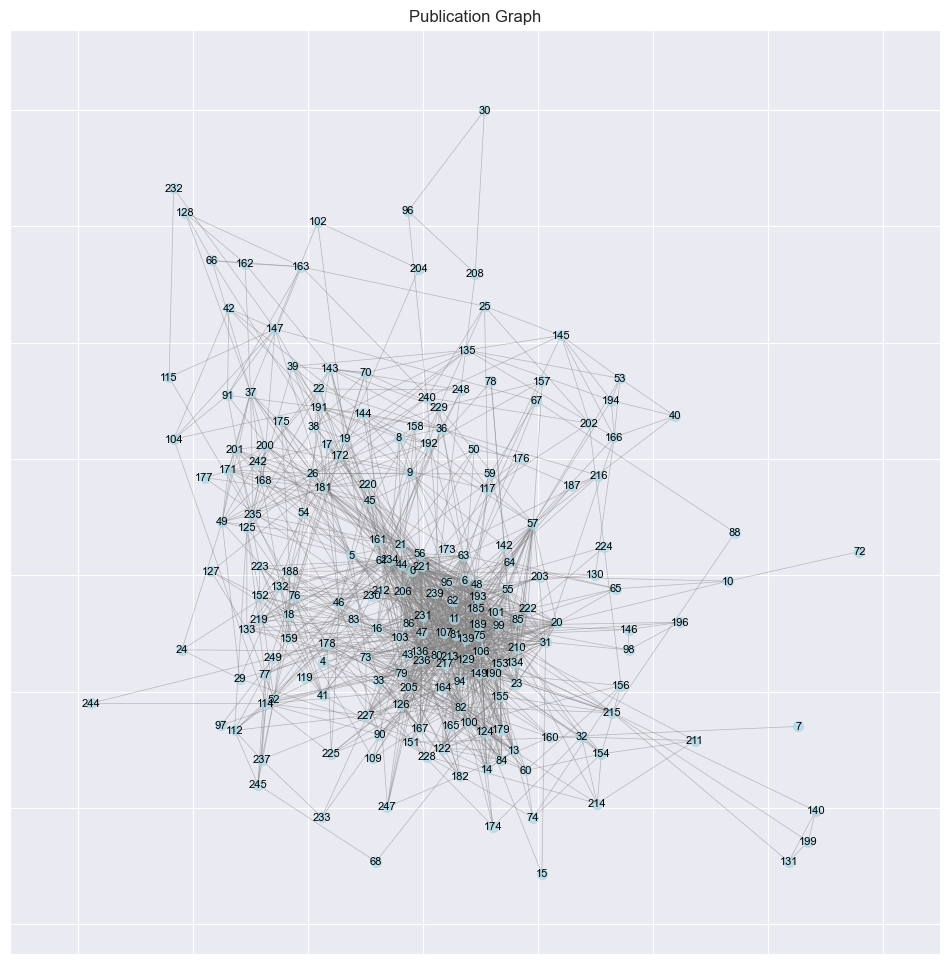

In [27]:
top_from = dict(
    pagerank = nx.pagerank(G_publications, weight='weight'),
    betweenness = nx.betweenness_centrality(G_publications, weight='weight'),
    degree_centrality_publications = nx.degree_centrality(G_publications)
)

top_from = {
    key: sorted(value.items(), key=lambda x: x[1], reverse=True)[:5]
    for key, value in top_from.items()
}

for (key, values) in top_from.items():
    values = [f"{df.loc[idx, 'title']}: {score}" for idx, score in values]
    print(f"Top 5 {key}:", *values, sep='\n', end='\n\n')


plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_publications, seed=52, k=5, iterations=1000)
nx.draw_networkx_nodes(G_publications, pos, node_size=50, node_color='lightblue', alpha=0.7)
nx.draw_networkx_edges(G_publications, pos, width=0.5, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G_publications, pos, font_size=8, font_color='black')
plt.title("Publication Graph")
plt.show()

In [28]:
target = 515

df.iloc[target, :].cleaned_keywords

IndexError: single positional indexer is out-of-bounds

In [106]:
neighbors = list(G_publications.neighbors(target))
sorted_neighbors = sorted(neighbors, key=lambda x: G_publications[target][x]['weight'], reverse=True)

sorted_neighbors

[554, 937, 625, 653, 845]

In [107]:
print(f"TOP-5 nearest for '{df.loc[target, 'title']}':")
for neighbor in sorted_neighbors[:5]:
    print(f"Publication: {df.loc[neighbor, 'title']}, weight: {G_publications[target][neighbor]['weight']}")

TOP-5 nearest for 'The repetition threshold for ternary rich words':
Publication: Avoiding abelian and additive powers in rich words, weight: 2
Publication: The Lexicographically Least Binary Rich Word Achieving the Repetition
  Threshold, weight: 2
Publication: The Repetition Threshold for Rote Sequences, weight: 1
Publication: Repetition Threshold for Binary Automatic Sequences, weight: 1
Publication: A small morphism giving Abelian repetition threshold less than 2, weight: 1
